In [0]:
# All your import statements here
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, cho_solve, cho_factor
import tensorflow as tf
from matplotlib import cm
from matplotlib import gridspec
import itertools
import sys
is_colab = 'google.colab' in sys.modules
print(is_colab)
print(sys.version)

True
3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [0]:
# define the matplotlib function to be used
# def plot(img):
#   plt.figure()
#   plt.contourf(img, cmap=plt.cm.Blues)
#   plt.colorbar()
#   plt.show()
#   return
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

def plot_2d(Z):
  x1 = np.arange(-25, 25, 1)
  x2 = np.arange(-25, 25, 1)
  X, Y = np.meshgrid(x1, x2)
    
  fig = plt.figure()
  ax = fig.gca(projection='3d')

  # Plot the surface.
  surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

  up_lim = np.max(Z)
  down_lim = np.min(Z)
  # Customize the z axis.
  ax.set_zlim(down_lim+0.3*down_lim, up_lim+0.3*up_lim)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  plt.show()

In [0]:
def plot_1d(x):
  fig = plt.figure()
  plt.plot(range(x.shape[0]), x)
  plt.show()
  return

In [0]:
# generate data either complete or with missing observations
NOISE = 0.1
def generate_data(frequency=5, noise=False):
  Fs = 150.0;  # sampling rate
  Ts = 1.0/Fs; # sampling interval
  t = np.arange(0,1,Ts) # time vector

  ff = 5;   # frequency of the signal
  y = np.sin(2*np.pi*ff*t)   + np.sin(2*np.pi*10*t) + np.sin(2*np.pi*15*t) + np.sin(2*np.pi*30*t)
  # y = 0.25 * (t-0.5)**2
  # y = 0.25 * (t-0.5)**3 + 0.5 * (t-0.5)**3
  # add noise
  if noise:
    y += np.random.normal(0, NOISE, y.shape)
  return y, Fs

In [0]:
def fft(data, freq = 150.0):
  n = len(data) # length of the signal
  k = np.arange(-n//2, n//2, 1)
  T = n/freq
  frq = k/T # two sides frequency range
  frq = frq[range(n)] # one side frequency range
  Y = np.fft.fftshift(np.fft.fft(data))/n # fft computing and normalization
  Y = Y[range(n)]
  plt.figure()
  plt.plot(frq, abs(Y), 'r')
  plt.show()
  return

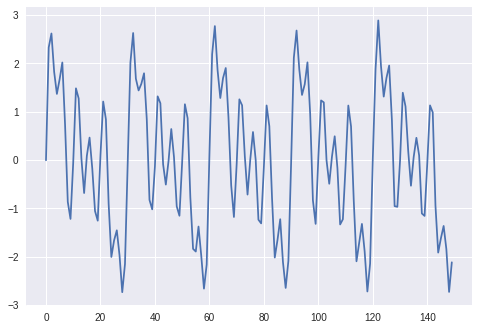

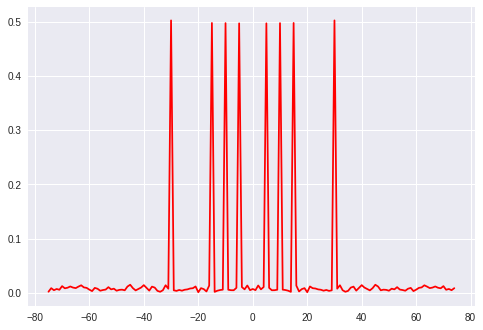

In [0]:
data, freq = generate_data(noise=True)
data
plot_1d(data)
fft(data)

In [0]:
# builds the naive GP covariance kernel
def squared_exponential_kernel(data, freq=150.0, l=0.001, sigma_f=5, noise=False):
  shape = data.shape[0]
  K = np.zeros((shape, shape))
  
  T = np.arange(0,1,1/freq)
  for i in range(shape):
    for j in range(shape):
      K[i, j] = sigma_f**2 * np.exp(-0.5 * np.abs(T[i]-T[j])**2/(l**2))
  
  if noise:
    K += NOISE * np.eye(K.shape[0])
    
  signal = np.zeros(2*shape-1)
  x_axis = np.concatenate((np.flip(-1.0*T, axis=0), T[1:]))
  count = 0
  for i in x_axis:
    signal[count] = sigma_f**2 * np.exp(-0.5 * (i)**2/(l**2))
    # signal[count] = np.exp(-2*np.pi**2*i**2) * np.sin(2*np.pi*i+0.5*np.pi) + np.exp(-2*np.pi**2*i**2) * np.sin(2*np.pi*i+0.5*np.pi) 
    if i == 0 and noise:
      signal[count] += NOISE
    count += 1
  return K, signal, x_axis

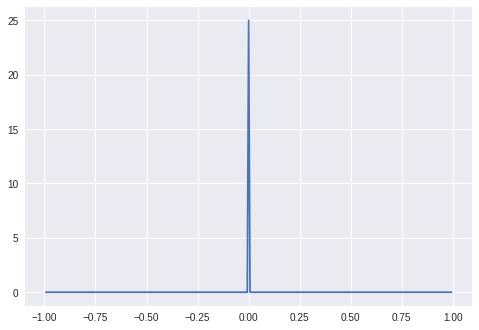

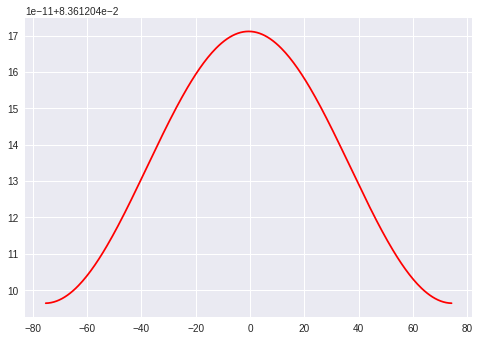

In [0]:
K, signal, x = squared_exponential_kernel(data, noise=False)
plt.figure()
plt.plot(x, signal)
plt.show()
fft(signal, freq=150.0)

In [0]:
# builds the naive GP covariance kernel
# def squared_exponential_kernel(data, freq=150.0, l=1.0, sigma_f=5):
#   shape = data.shape[0]
#   K = np.zeros((shape, shape))
#   for i in range(shape):
#     for j in range(shape):
#       K[i, j] = sigma_f**2 * np.exp(-0.5 * np.abs(i-j)**2/(l**2))
  
#   signal = np.zeros(2*shape-1)
#   x_axis = range(-1*(shape-1), shape)
#   count = 0
#   for i in x_axis:
#     signal[count] = sigma_f**2 * np.exp(-0.5 * i**2/(l**2))
#     count += 1
#   return K, signal, x_axis
# K, signal, x = squared_exponential_kernel(data)
# plt.figure()
# plt.plot(x, signal)
# plt.show()
# fft(signal, freq=150.0)

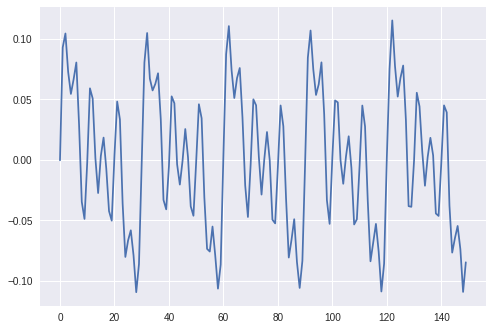

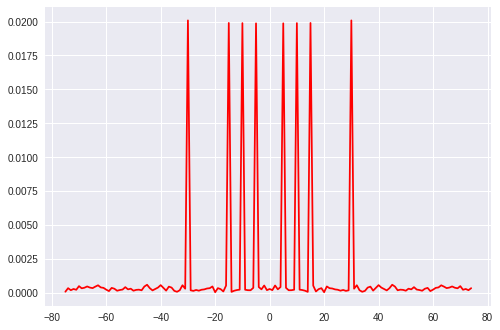

loss:2.4539268359856308e-30


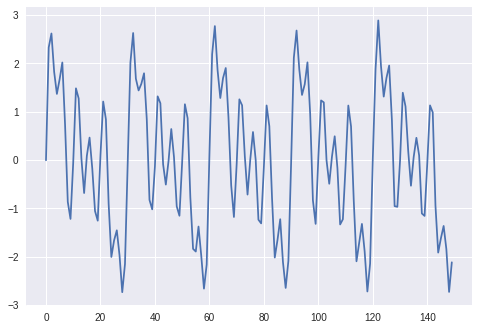

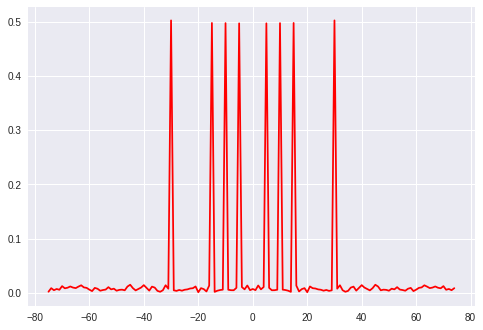

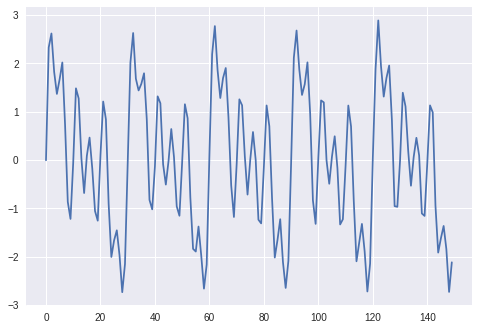

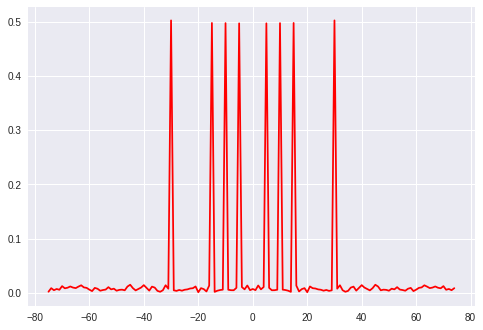

True


In [0]:
# L, lower = cho_factor(K)
v = np.linalg.solve(K, data)
plot_1d(v)
fft(v)
reconst = np.dot(K, v.T)
print('loss:'+str(np.sum((reconst-data)**2)))
plot_1d(reconst)
fft(reconst)
reconst = np.convolve(signal, v, mode='valid')
plot_1d(reconst)
fft(reconst)
print(np.allclose(reconst, data, atol=1e-15))

In [0]:
def convolution(N, kernel, y):
  tf.reset_default_graph()
  gr = tf.get_default_graph()
  y_flat = tf.convert_to_tensor(y)
  input_vector = np.array(kernel)
  
  # tensorflow
#   input_vector = np.expand_dims(input_vector, axis=0)
#   input_vector = np.expand_dims(input_vector, axis=2)
#   input_vector = np.expand_dims(input_vector, axis=3)
  
  input_vector = np.reshape(input_vector, (1, 1, input_vector.shape[0], 1))
  # tensorflow
  y_prime = tf.layers.conv2d(
          inputs=tf.convert_to_tensor(input_vector),
          filters=1,
          kernel_size=[1, N],
          name="conv1",
          use_bias=False,
          padding="valid")
  
  v_prime = gr.get_tensor_by_name('conv1/kernel:0')
  v = tf.reverse(v_prime, [-1])
  y_prime = tf.reshape(y_prime, [N])
  v = tf.reshape(v, [N])
  temp = y_flat - y_prime
  first = 0.5 * (1/NOISE**2) * tf.tensordot(temp, temp, 1)
  second = 0.5 * tf.tensordot(v, y_prime, 1)
  loss = (first + second)

  
  # add the D.v term
#   y_prime = tf.reshape(y_prime, [N*N])
#   v_prime = gr.get_tensor_by_name('conv1/kernel:0')
#   v = tf.reshape(v_prime, [N*N])
#   v = tf.reverse(v, [-1])
#   v = tf.expand_dims(v, 1)
#   temp = tf.matmul(noise, v)
#   temp = tf.reshape(temp, [N*N])
#   print(y_prime, v, noise, temp)
#   y_prime += temp
#   # l2 loss
#   loss = tf.reduce_sum(((y_prime - y_flat)*mask)**2)
  
  # conjugate gradient loss
#   first = 0.5 * tf.matmul(tf.transpose(v), y_prime)
#   first_noise = 0.5 * tf.matmul(tf.transpose(v), tf.matmul(noise, v))
#   second = -1.0 * tf.matmul(tf.transpose(v), tf.expand_dims(y_flat, 1))
#   print(first, second, first_noise)
#   loss = (first + second + first_noise)[0,0]
  
  # KL divergence loss
#   first = tf.matmul(tf.transpose(y_prime), v)
#   first_noise = tf.matmul(tf.transpose(y_prime), tf.matmul(noise, v))
#   loss = ((first + first_noise)/N)[0, 0]
  # optimization step
  optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
  init_op = tf.global_variables_initializer()

  with tf.Session() as sess:
    sess.run(init_op)
    loss_plot = []
    for i in range(5000):
      sess.run(optimizer)
      # print(sess.run(conv1))
      # recover graph
      if i%100 == 0:
        gr = tf.get_default_graph()
        v = gr.get_tensor_by_name('conv1/kernel:0').eval()
        v = np.flip(np.reshape(v, (N,)), axis=0)
        # plot new image
        img = y_prime.eval({}, sess)
        loss = np.sum(((y - img))**2) 
        print('loss: ', loss)
        loss_plot.append(loss)
        plt.figure()
        plt.plot(img)
        plt.show()
  plt.plot(loss_plot)
  print(np.allclose(y, img, atol=1e-15))
  fft(v)
  sess.close()
  return img

In [0]:
y_prime = convolution(data.shape[0], signal, data)